# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import h5py
import re
from typing import Optional

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_NMF_components, plot_position_frequency_map
from src.models import nmf_missing

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

In [3]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

# Define Paths

In [4]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [5]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3981, 822)

# Read metadata

In [6]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Dcum2,QPS Crate,QPS Board,#Segment,phys_pos,Name,R_1,R_2,RRR_1,RRR_2
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,268.9040,B8R1,0,79,1,A8R1,1.80,1.85,95.650088,94.103943
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,284.5640,B9R1,0,77,2,B8R1,1.67,1.85,100.314516,94.103943
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,307.9690,B8R1,1,80,3,A9R1,1.75,1.85,97.936878,94.103943
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,323.6290,B11R1,2,76,4,B9R1,1.67,1.77,100.314516,97.371760
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,348.4340,B10R1,0,81,5,A10R1,1.67,1.67,100.314516,100.314516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,26294.7892,B10L1,1,75,150,A10L1,2.53,3.13,78.314002,70.353447
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,26319.5942,B9L1,1,80,151,B9L1,3.25,3.70,68.099268,54.735949
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,26335.2542,B10L1,2,76,152,A9L1,3.09,1.75,70.748254,99.628927
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,26358.6592,B9L1,0,79,153,B8L1,2.43,2.43,79.915648,79.899869


# Read position map

In [7]:
pos_map_path = Path("..\data\circuit_sort.csv")
df_pos_map = pd.read_csv(pos_map_path)
df_pos_map = df_pos_map.set_index(['Circuit', 'El. Quench Position', 'Phys. Quench Position']) # allows faster indexing
df_pos_map

Magnet  El. Position  \
Circuit El. Quench Position Phys. Quench Position                          
RB.A12  6                   141                    MB.A8L2             0   
RB.A45  88                  130                    MB.B8R4             0   
RB.A34  59                  34                     MB.B8L4             0   
RB.A12  44                  65                     MB.A8L2             0   
        27                  99                     MB.A8L2             0   
...                                                    ...           ...   
RB.A34  32                  88                     MB.A8L4           153   
RB.A67  146                 15                     MB.B8R6           153   
RB.A45  110                 86                     MB.A8R4           153   
RB.A12  5                   143                    MB.B8L2           153   
RB.A78  2                   149                    MB.B8L8           153   

                                                   Phys. Position  \
Circuit El. Quench Position Phys. Quench Position                   
RB.A12  6                   141                               153   
RB.A45  88                  130                                 1   
RB.A34  59                  34                                152   
RB.A12  44                  65                                153   
        27                  99                                153   
...                                                           ...   
RB.A34  32                  88                                153   
RB.A67  146                 15                                  1   
RB.A45  110                 86                                  0   
RB.A12  5                   143                               152   
RB.A78  2                   149                               152   

                                                   Phys. Dist. to PC  \
Circuit El. Quench Position Phys. Quench Position                      
RB.A12  6                   141                                    0   
RB.A45  88                  130                                  153   
RB.A34  59                  34                                     1   
RB.A12  44                  65                                     0   
        27                  99                                     0   
...                                                              ...   
RB.A34  32                  88                                     0   
RB.A67  146                 15                                   153   
RB.A45  110                 86                                   152   
RB.A12  5                   143                                    1   
RB.A78  2                   149                                    1   

                                                   Phys. Position ODD  \
Circuit El. Quench Position Phys. Quench Position                       
RB.A12  6                   141                                   153   
RB.A45  88                  130                                     1   
RB.A34  59                  34                                    152   
RB.A12  44                  65                                    153   
        27                  99                                    153   
...                                                               ...   
RB.A34  32                  88                                    153   
RB.A67  146                 15                                      1   
RB.A45  110                 86                                      0   
RB.A12  5                   143                                   152   
RB.A78  2                   149                                   152   

                                                   Phys. Position EVEN  \
Circuit El. Quench Position Phys. Quench Position                        
RB.A12  6                   141                                      1   
RB.A45  88                  130                         

# Load Data

In [8]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

fpa_identifiers = mp3_fpa_df[#(mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 > sec_after_prim_quench) &
                             (mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)
                             ].fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# postprocess fft data
data_1EE_ff_scaled = np.array([dataset_creator_1EE.log_scale_data(x) for x in dataset_1EE_fft.data])
data_2EE_ff_scaled = np.array([dataset_creator_2EE.log_scale_data(x) for x in dataset_2EE_fft.data])
data_1EE = np.nan_to_num(data_1EE_ff_scaled.reshape(-1, np.shape(data_1EE_ff_scaled)[2]))
data_2EE = np.nan_to_num(data_2EE_ff_scaled.reshape(-1, np.shape(data_2EE_ff_scaled)[2]))

# Non-negative components - NMF

In [9]:
def plot_nmf_event_composition(data_1EE, W, H, component_indexes, dataset_1EE_fft, fpa_identifier, mp3_fpa_df):   
    # get right event index
    all_fpa_identifiers = mp3_fpa_df[(mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)].fpa_identifier.unique()
    fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)]
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
    
    # get context data of event
    date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
    mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.fpa_identifier == fpa_identifier) & (mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5)]
    current = mp3_fpa_df_subset['I_end_2_from_data'].max()
    prim_quench_position = mp3_fpa_df_subset['#Electric_circuit'].values[0]
    sec_quench_position = mp3_fpa_df_subset['#Electric_circuit'].values[1:]
    sec_quench_times = mp3_fpa_df_subset['Delta_t(iQPS-PIC)'].values[1:] 
    sec_quench_el = [f"{int(pos)}@{int(time)}ms" for pos, time in zip(sec_quench_position, sec_quench_times)]

    # plot event
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, axes = plt.subplots(len(component_indexes),8, figsize = (20, 2.5 * len(component_indexes)), gridspec_kw={'width_ratios': [2, 0.1, 2, 2, 0.1, 2, 0.1, 2]})
    for i, ax in enumerate(axes[:, 0]):
        if i ==0:
            plot_position_frequency_map(ax, data_1EE[event_idex*154:event_idex*154+154], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1)
            ax.set_ylabel('Frequency / Hz')
            ax.set_xlabel('El. Position')
        else: 
            ax.axis('off')
            
    # plot reconstructed event event
    for i, ax in enumerate(axes[:, -1]):
        if i ==0:
            plot_position_frequency_map(ax, W[event_idex*154:event_idex*154+154]  @ H, dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1)
            ax.set_ylabel('Frequency / Hz')
            ax.set_xlabel('El. Position')
        else: 
            ax.axis('off')
            
    # plot components
    for k, i in enumerate(component_indexes): 
        if isinstance(i, list):
            W_temp = 0
            H_temp = 0
            data_reconstructed = 0
            for j in i: 
                W_temp += W[event_idex*154:event_idex*154+154, j:j+1]
                H_temp += H[j:j+1] 
            H_temp /= len(i) # sum components, mean weight, or other way around
        else: 
            W_temp = W[event_idex*154:event_idex*154+154, i:i+1] 
            H_temp = H[i:i+1] 
        data_reconstructed = W_temp @ H_temp

        axes[k, 3].plot(W_temp, c=default_colors[k])
        axes[k, 2].plot(dataset_1EE_fft.frequency, H_temp.T, c=default_colors[k])
        plot_position_frequency_map(axes[k,5], data_reconstructed, dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1)

        axes[k, 2].set_ylabel('Voltage / V')
        axes[k, 3].set_ylabel('Voltage / V')
        axes[k, 5].set_ylabel('Frequency / Hz')

        if k < len(component_indexes) - 1:
            axes[k,2].set_xticks([])
            axes[k,3].set_xticks([])
            axes[k,5].set_xticks([])
        else:
            axes[k, 2].set_xlabel('Frequency / Hz')
            axes[k, 3].set_xlabel('El. Position')
            axes[k, 5].set_xlabel('El. Position')

    axes[1,0].text(0,0.8,f"Event: {fpa_identifier}\nDate: {date}\n$i$={event_idex*154}\n\nMax Current: {current} A\nEl. Prim Quench Position: {prim_quench_position}\nEl. Sec. Quench Position@Time:\n{sec_quench_el}", va="top")

    [ax.axis('off') for ax in axes[:, 1]]
    [ax.axis('off') for ax in axes[:, 4]]
    [ax.axis('off') for ax in axes[:, 6]]

    axes[0,0].set_title("Input Event\n$V_{:,i:i+154}$", fontsize=12)
    axes[0,1].set_title(f"$\sim\sum_{{k=1}}^{{r={len(component_indexes)}}}$", fontsize=15)
    axes[0,2].set_title("Components $k$\n$W_k$", fontsize=12)
    axes[0,3].set_title("Components Weight\n$H_{k,i:i+154}$", fontsize=12)
    axes[0,4].set_title(f"$=\sum_{{k=1}}^{{r={len(component_indexes)}}}$", fontsize=15)
    axes[0,5].set_title("Reconstructed Components\n$WH_{k,i:i+154}$", fontsize=12)
    axes[0,6].set_title("=", fontsize=15)
    axes[0,7].set_title("Reconstructed Event\n$WH_{:,i:i+154}$", fontsize=12)

    plt.tight_layout(h_pad=-2, w_pad=0.1)
    #return fig, axes

In [10]:
def plot_nmf_components(H, dataset_1EE_fft, event_idex=1, component_indexes=None):
    fig, ax = plt.subplots(figsize = (12,5))
    if component_indexes is None:
        component_indexes = np.arange(len(H))
        
    for k, i in enumerate(component_indexes): 
            if isinstance(i, list):
                H_temp = 0
                data_reconstructed = 0
                for j in i: 
                    H_temp += H[j:j+1] 
            else: 
                H_temp = H[i:i+1] 

            ax.plot(dataset_1EE_fft.frequency, H_temp.T, label=f"component {i}")
            ax.set_xlabel('Frequency / Hz')
            ax.set_ylabel('Voltage / V')
    ax.set_xlim([dataset_1EE_fft.frequency.values.min(), dataset_1EE_fft.frequency.values.max()])
    ax.grid()
    plt.legend()

In [11]:
all_fpa_identifiers = mp3_fpa_df[(mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)].fpa_identifier.unique()
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)]

use_fpa_identifier = False
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A23_1620923593800000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 1 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

(1,
 array('RB_RB.A78_1615271973700000000', dtype='<U29'),
 '2021-03-09 07:39:33.678000')

## 1st Energy Extraction Plateau

In [12]:
n_components = 10
W_1EE, H_1EE, n_iter = nmf_missing.non_negative_factorization(data_1EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1)

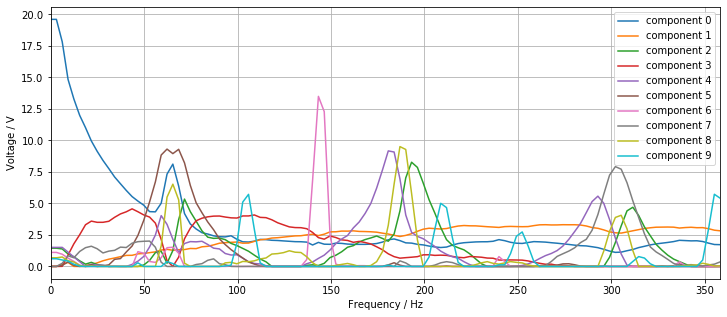

In [13]:
plot_nmf_components(H_1EE, dataset_1EE_fft)

### Check components

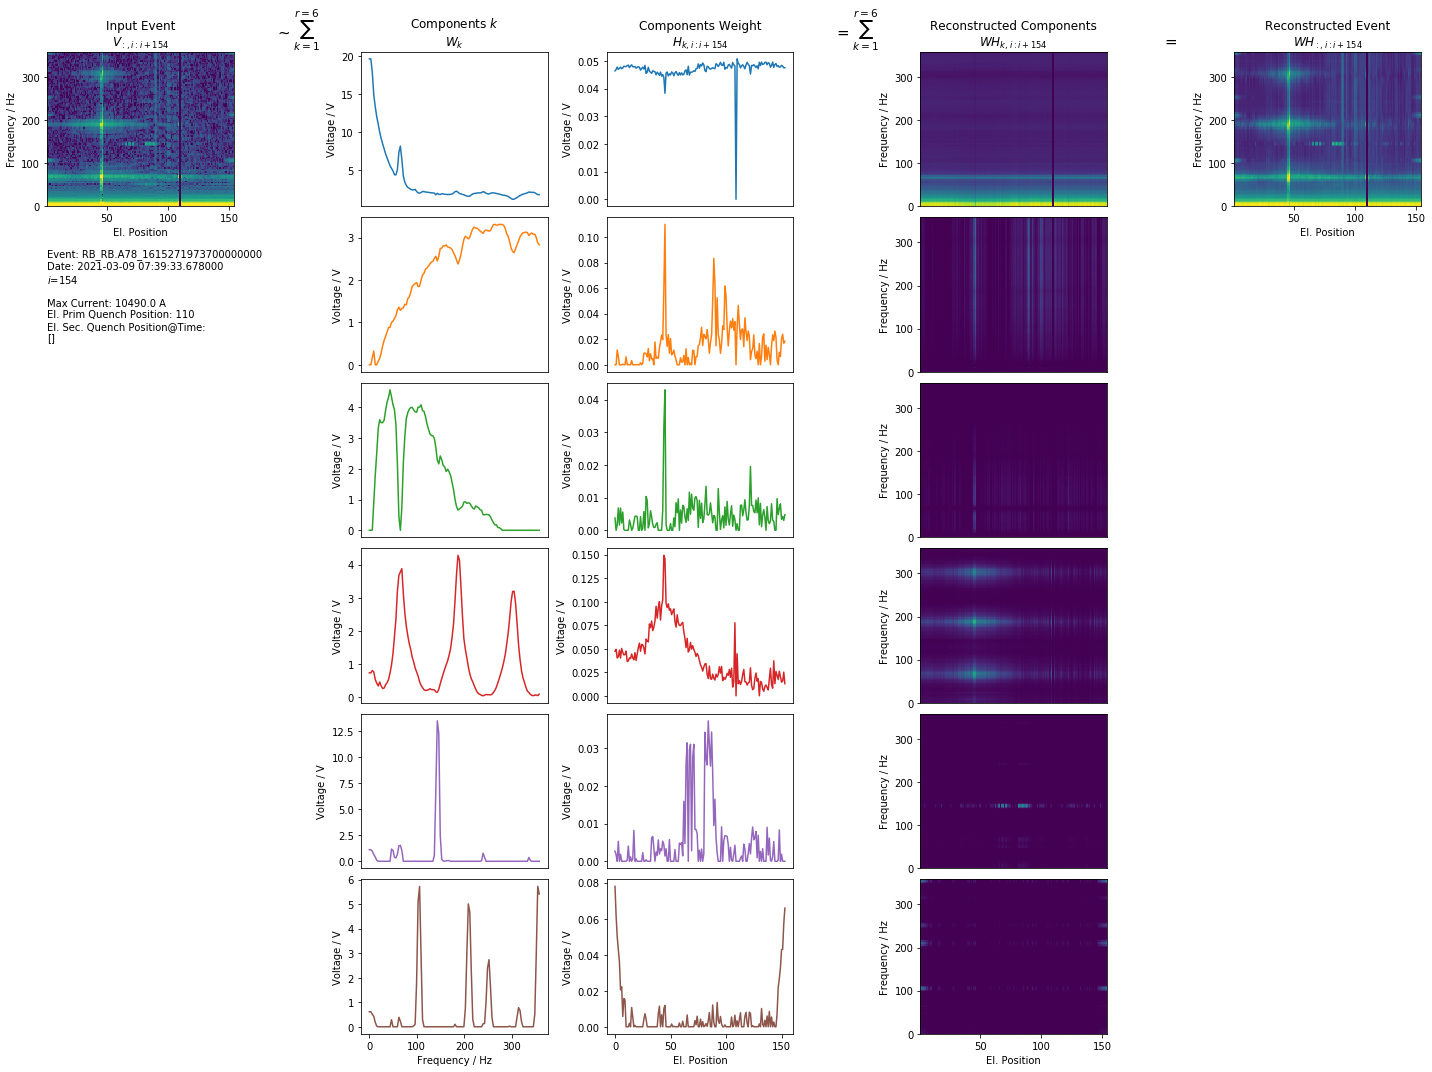

In [14]:
component_indexes_1EE = [0, 1, 3, [2,4,5,7,8], 6, 9]
plot_nmf_event_composition(data_1EE, W_1EE, H_1EE, component_indexes_1EE, dataset_1EE_fft, fpa_identifier, mp3_fpa_df)

### Distribution of Component weights

In [15]:
def map_position_index(pos_map, origin="El. Position", to="Phys. Position", filt: Optional[dict]=None, old_index: Optional[np.array]=None):
    """
    function maps origin index to new index. E.g. RB.A12 origin="El. Position"=[0, ..., 154] -> to="Phys. Position"=[78, ..., 1]
    :param pos_map: lookup table to map positions
    :param origin: origin index name with which the data is sorted, E.g. "El. Position"
    :param to: origin index name with which the data is sorted, E.g. "Phys. Position"
    :return: electrical position array index
    """

    if old_index is None:
        old_index = np.arange(0,154)
 
    pos_map_subset = pd_dict_filt(pos_map, filt) #0.06s - too slow
    new_index = pos_map_subset.sort_values(by=to)[origin].values #  & (pos_map.quench_pos == quench_pos)
    not_nan_values = pos_map_subset.sort_values(by=to)[to].values >= 0
    new_index = new_index[old_index][not_nan_values[old_index]].astype(int)
    return new_index

def nanargsort(array: np.array) -> np.array:
    """
    argsort with dropna
    :param array: array to sort
    :return: index of sorted array without nan
    """
    return np.argsort(array)[(np.sort(array) >=0)]

def pd_dict_filt(df, filt):
    """
    filters pandas DataFrame by dictonary, keys of filt must be in df (multi)index 
    :param df: DataFrame to filer
    :param filt: dict with key columns and args values, equal to df[df[key]== values]
    :return: filtered DataFrame
    """
    if filt is None:
        return df
    else:
        level = list(np.argwhere(np.isin(df.index.names, list(filt.keys()))).flatten())
        return df.xs(tuple(filt.values()), level=level)
    
def merge_matrix(matrix, merge_index, axis=-1, func=np.mean):
    matrix_merged = [list(func(matrix[... ,i], axis=axis)) if isinstance(i, list) else list(matrix[... ,i]) for i in merge_index]
    return np.moveaxis(matrix_merged, 0, -1)#(matrix_merged)


def signaltonoise(m, sd):
    snr = abs(np.where(np.nan_to_num(sd) == 0, 0, m/sd))
    return snr

In [16]:
n_components =10
H_1EE_merged = H_1EE.copy().T
component_weights_1EE_merged = W_1EE.copy().reshape(-1, 154, n_components)

merge_components = True
merge_component_index = [0, 1, 3, [2,4,5,7,8], 6, 9]
H_1EE_merged = merge_matrix(H_1EE_merged, merge_component_index, axis=-1, func=np.sum).T
component_weights_1EE_merged = merge_matrix(component_weights_1EE_merged, merge_component_index, axis=-1, func=np.mean)

max_H = H_1EE_merged.max(axis=1, keepdims=True)
H_1EE_processed = H_1EE_merged / max_H
component_weights_1EE = component_weights_1EE_merged * np.expand_dims(max_H.T, axis=0)

In [17]:
mp3_fpa_df_subset = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers)]
mp3_fpa_df_pos_subset = mp3_fpa_df_subset.rename(columns={'#Electric_circuit':"El. Quench Position", 'phys_position': "Phys. Quench Position"})
mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] = mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] - 1

el_filt_list = mp3_fpa_df_pos_subset[['Circuit', "El. Quench Position"]].to_dict(orient='records')
phys_filt_list = mp3_fpa_df_pos_subset[['Circuit', "Phys. Quench Position"]].to_dict(orient='records')

In [18]:
sort_columns = ['El. Position', 'Phys. Position', 'Phys. Position ODD', 'Phys. Position EVEN', 'Phys. Dist. to PC', 'Phys. Dist. to Quench', 'El. Dist. to Quench Main', 'El. Dist. to Quench Mirror']

c_weights_dict = {}
current_sort = 'El. Position'
for target in sort_columns:
    print(target)
    max_index = int(df_pos_map[target].max())
    if "El." in target:
        filt_list = el_filt_list
    elif "Phys." in target:
        filt_list = phys_filt_list
        
    mask = np.empty((component_weights_1EE.shape[0], max_index+1, component_weights_1EE.shape[-1])) * np.nan
    for i, f in enumerate(filt_list):
        index = map_position_index(df_pos_map, origin=current_sort, to=target, filt=f)
        target_index = map_position_index(df_pos_map, origin=target, to=target, filt=f)
        mask[i][target_index] = component_weights_1EE[i][index]

    if 'Quench' in target: 
        x_label = np.arange(-int((max_index+1)/2),  int((max_index+2)/2))
    else:
        x_label = np.arange(1, int(max_index+2))
            
    c_weights_dict[target] = {"values": mask,
                             "index": x_label}

El. Position
(1, 154)
Phys. Position
(1, 154)
Phys. Position ODD
(1, 154)
Phys. Position EVEN
(1, 154)
Phys. Dist. to PC
(1, 154)
Phys. Dist. to Quench
(-154, 153)
El. Dist. to Quench Main
(-77, 76)
El. Dist. to Quench Mirror
(-77, 76)


In [19]:
# add snr for each method
for sort in c_weights_dict:
    y = np.nanmean(c_weights_dict[sort]["values"], axis=0)
    error = np.nanstd(c_weights_dict[sort]["values"], axis=0)
    c_weights_dict[sort]["snr"] = np.nanmean(signaltonoise(y, error), axis=0)

In [20]:
def plot_avg_component_weight(ax, c_weights, component_number, xlabel):
    
    y = np.nanmean(c_weights["values"], axis=0)[:, component_number]
    #y_med = np.nanmedian(c_weights["values"], axis=0)[:, component_number]
    error = np.nanstd(c_weights["values"], axis=0)[:, component_number] 
    upper_error = np.nanquantile(c_weights["values"], q=0.75, axis=0)[:, component_number]
    lower_error = np.nanquantile(c_weights["values"], q=0.25, axis=0)[:, component_number]
    
    n_components = c_weights["values"].shape[-1]
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ck = component_number % len(default_colors)
    
    ax.plot(c_weights["index"], y, c=default_colors[ck])
    #ax.plot(c_weights["index"], y_med, c=default_colors[ck], ls="--")
    #ax.plot(c_weights["index"], y, c=default_colors[ck], marker="x")
    ax.set_title(f"Average Component {component_number} Weight\nSNR: {np.mean(signaltonoise(y, error)):.2f}")
    ax.set_xlabel(xlabel)
    ax.fill_between(c_weights["index"], lower_error, upper_error, alpha=0.1, edgecolor=default_colors[ck], facecolor=default_colors[ck])

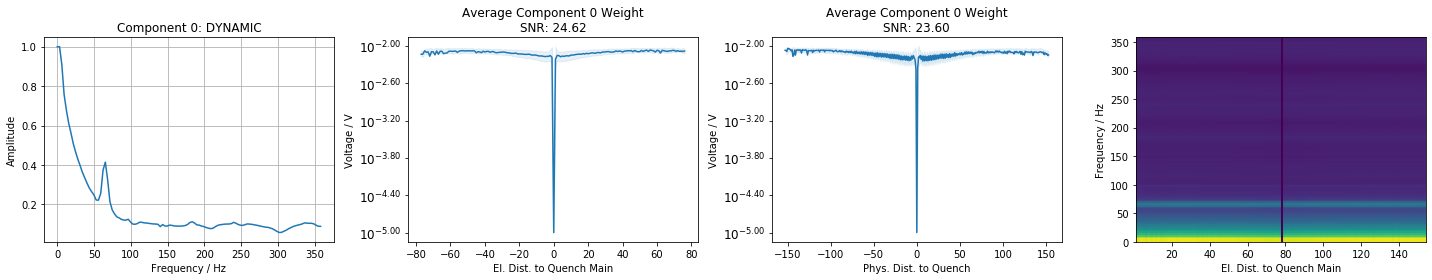

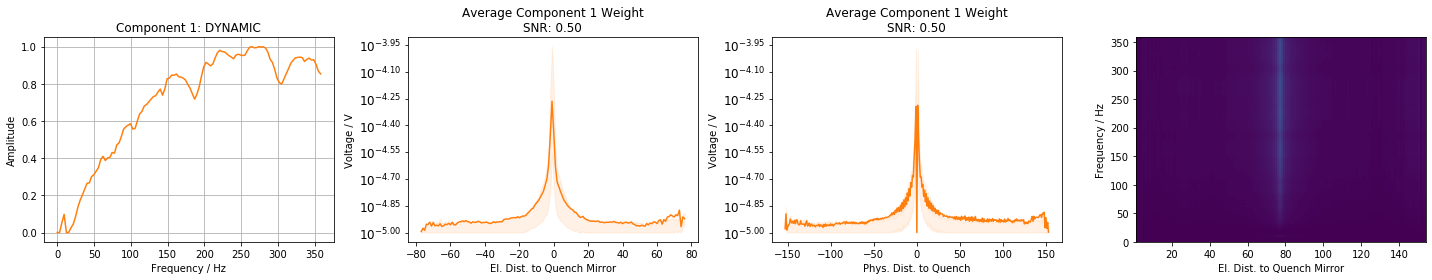

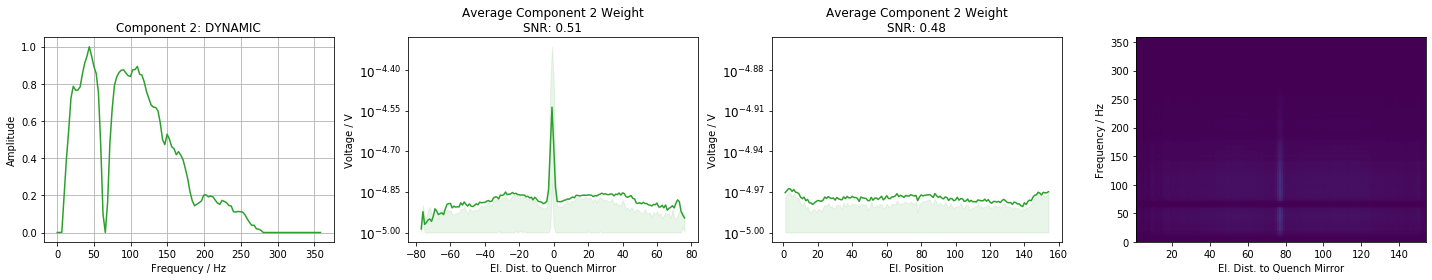

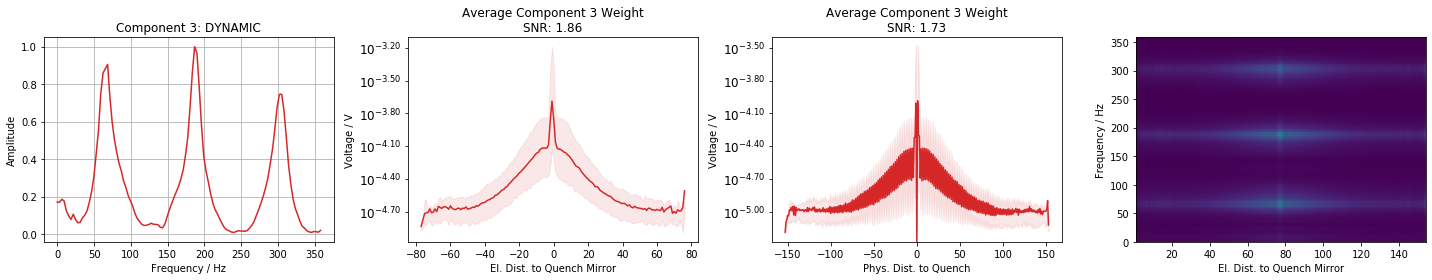

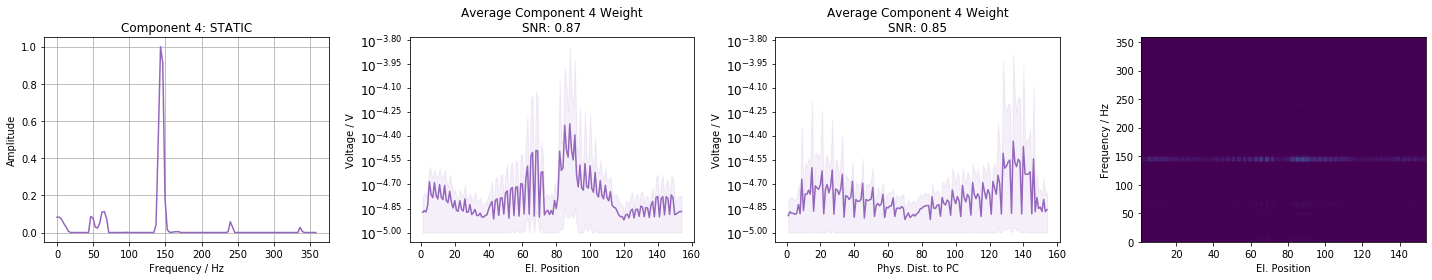

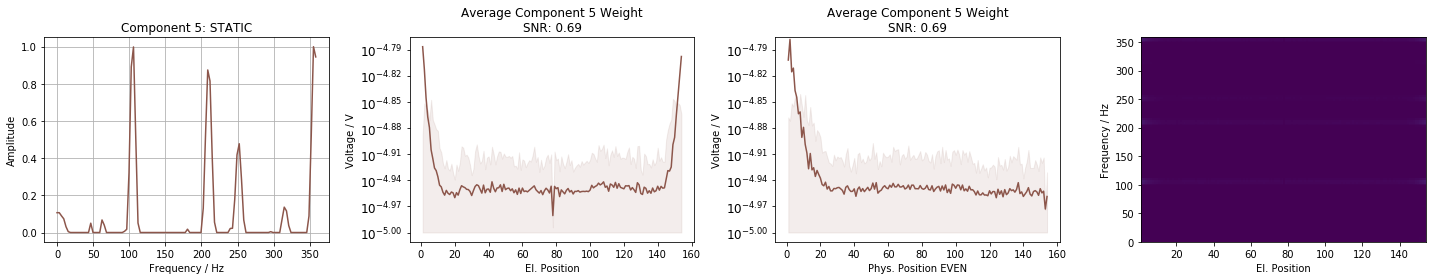

In [21]:
plot_n_highest_snr =  2#len(c_weights_dict)
n_components = c_weights_dict["El. Position"]["values"].shape[-1]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2

best_sort_index = []
for k in range(n_components): 
    
    snr_sorted_index = np.argsort([-c_weights_dict[sort]["snr"][k] for sort in c_weights_dict])[:plot_n_highest_snr]
    best_sort_index.append(snr_sorted_index[0])
    
    fig, ax = plt.subplots(1,plot_n_highest_snr+2, figsize =(5*(plot_n_highest_snr+2),4))
    ax[0].plot(dataset_1EE_fft.frequency, H_1EE_processed[k], c=default_colors[k % n_components])
    ax[0].set_title(f"Component {k}")
    ax[0].set_xlabel("Frequency / Hz")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid()
    
    if "Quench" in list(c_weights_dict)[snr_sorted_index[0]]:
        ax[0].set_title(f"Component {k}: DYNAMIC")
    else:
        ax[0].set_title(f"Component {k}: STATIC")
    
    for i, sort in enumerate(np.array(list(c_weights_dict))[snr_sorted_index]):
        plot_avg_component_weight(ax[i+1], c_weights_dict[sort], component_number=k, xlabel=sort)
        
        yticks = ax[i+1].get_yticks().tolist()
        
        ax[i+1].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
        ax[i+1].set_ylabel("Voltage / V")
        ax[i+1].set_ylim(ax[1].get_ylim())

    
    best_sort = list(c_weights_dict)[snr_sorted_index[0]]
    V_mean = np.nanmean(c_weights_dict[best_sort]["values"], axis=0)[:, k:k+1] @  H_1EE_processed[k:k+1]
    plot_position_frequency_map(ax[-1], V_mean, dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1)
    ax[-1].set_xlabel(best_sort)
    ax[-1].set_ylabel("Frequency / Hz")
    
    plt.tight_layout()
    

 divide dependent on position in cryostat
rb_magnet_metadata['cryostat_group'] = rb_magnet_metadata['Cryostat2'].apply(lambda x: x.split('_')[1])
last_mpos_in_cryostat = rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit].groupby("cryostat_group").min().sort_values(by='phys_pos').phys_pos.values
cryostat_position = [rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit].groupby("cryostat_group").nth(i).sort_values(by='phys_pos').phys_pos.values for i in range(3)]

### Simulate FP-map given components

In [22]:
def main_mirror_to_el(V_main, V_mirror, quench_pos):
    V_mean = np.zeros_like(V_main)
    center = int(len(V_mean) /2)
    if quench_pos > center: #quench in second half
        V_mean[center:] = np.roll(V_main, -center +quench_pos, axis=0)[center:]
        V_mean[:center] = np.roll(V_mirror, center - quench_pos, axis=0)[:center]
    else: 
        V_mean[:center] = np.roll(V_main, -center +quench_pos, axis=0)[:center]
        V_mean[center:] = np.roll(V_mirror, 153 - center - quench_pos, axis=0)[center:]
    return V_mean

In [23]:
n_quench_pos = 154
V_mean_1EE = np.zeros((n_quench_pos,) + dataset_1EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index):
        best_sort = list(c_weights_dict)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)
        V_mean_1EE[quench_pos] += V_mean

# ifft

In [ ]:
def ifft_amplitude(x_fft, freq, t):
    x_t = np.zeros_like(t)
    for f, x in zip(freq, x_fft):
        x_t += x*np.sin(f*2*np.pi*t)
    return x_t

In [ ]:
t = dataset_1EE.time.values - dataset_1EE.time.values[0]

x_fft = np.sum(V_mean_all, axis=0)[0]
x_fft_unscaled = np.power(10, 3*x_fft-5) #* len(x_fft)

x_reconstructed = ifft_amplitude(x_fft_unscaled, dataset_1EE_fft.frequency.values, t) #ifft2

plt.plot(x_fft_unscaled)
plt.title(x_fft.shape)
plt.show()
plt.plot(x_reconstructed )
plt.title(x_reconstructed.shape)
plt.show()

## 2nd Energy Extraction Plateau

In [24]:
n_components = 12
W_2EE, H_2EE, n_iter = nmf_missing.non_negative_factorization(data_2EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1, max_iter=200)

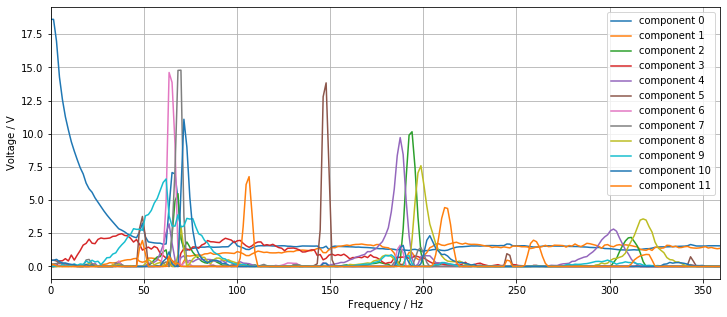

In [25]:
plot_nmf_components(H_2EE, dataset_2EE_fft)

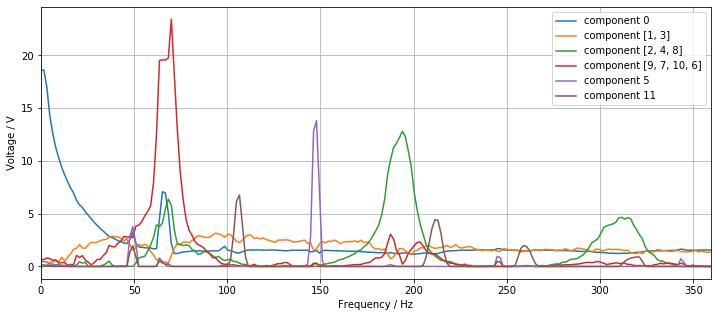

In [26]:
component_indexes_2EE = [0, [1,3], [2,4,8], [9, 7,10,6], 5, 11]
plot_nmf_components(H_2EE, dataset_2EE_fft, component_indexes=component_indexes_2EE)

### Check components

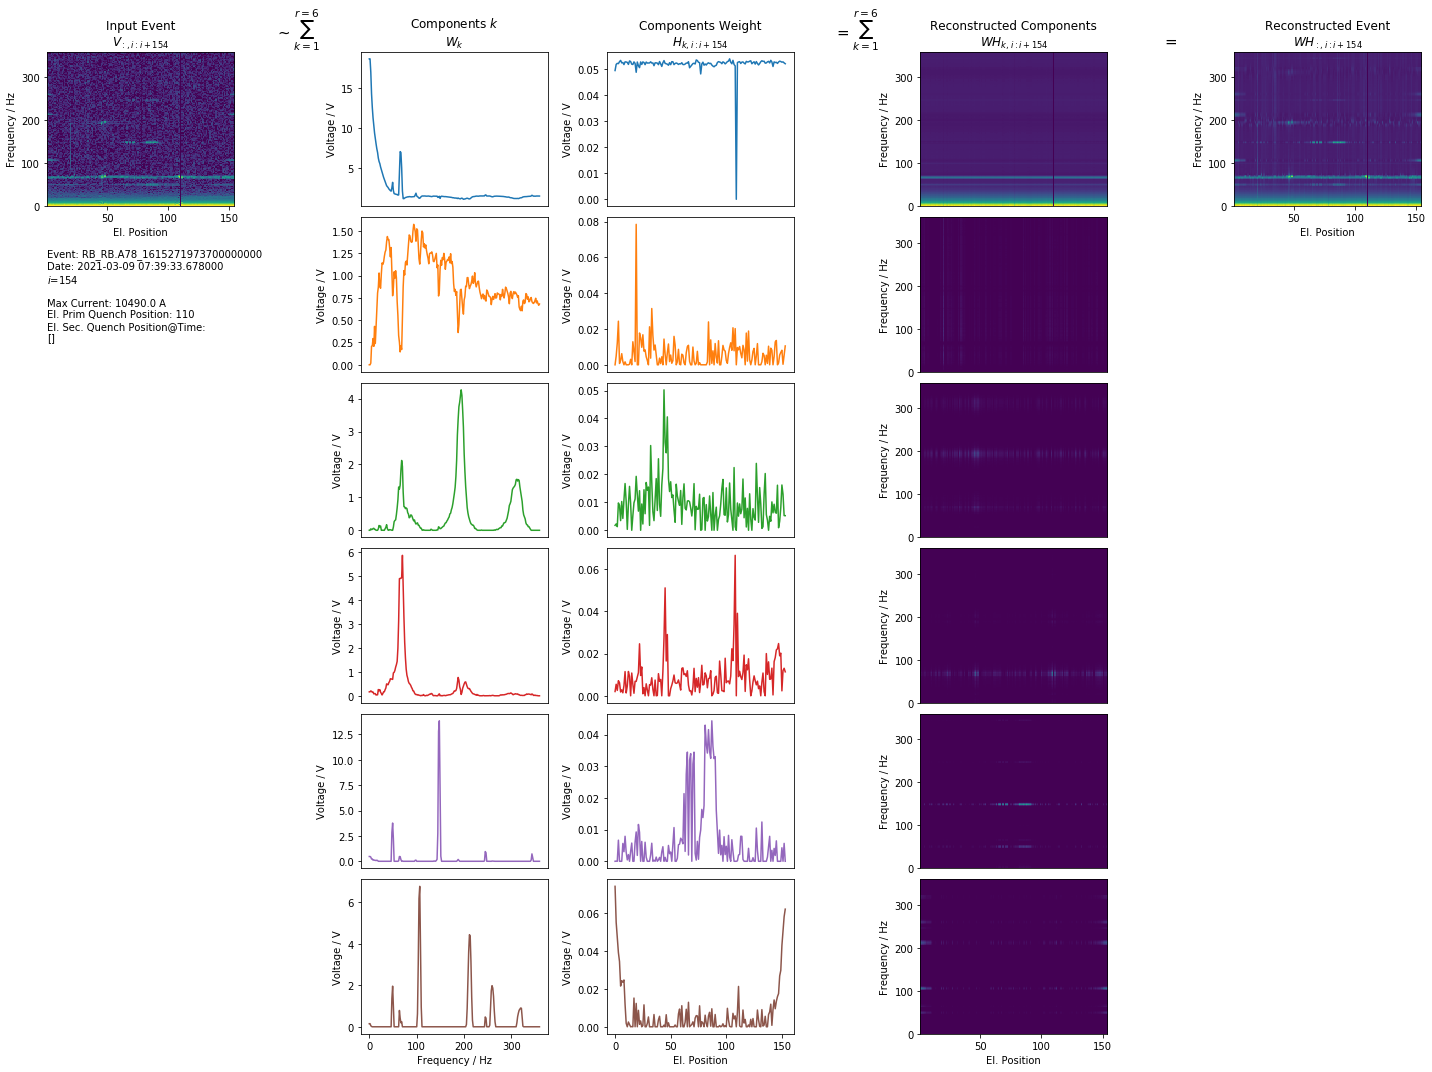

In [27]:
plot_nmf_event_composition(data_2EE, W_2EE, H_2EE, component_indexes_2EE, dataset_2EE_fft, fpa_identifier, mp3_fpa_df)

### Distribution of Component weights

In [28]:
n_components =12
H_2EE_merged = H_2EE.copy().T
component_weights_2EE_merged = W_2EE.copy().reshape(-1, 154, n_components)

merge_components = True
merge_component_index = [0, [1,3], [2,4,8], [9, 7,10,6], 5, 11]
if merge_components:
    H_2EE_merged = merge_matrix(H_2EE_merged, merge_component_index, axis=-1).T
    component_weights_2EE_merged = merge_matrix(component_weights_2EE_merged, merge_component_index, axis=-1)

normalize_components = True
if normalize_components:
    max_H = H_2EE_merged.max(axis=1, keepdims=True)
    H_2EE_processed = H_2EE_merged / max_H
    component_weights_2EE = component_weights_2EE_merged * np.expand_dims(max_H.T, axis=0)

In [30]:
sort_columns = ['El. Position', 'Phys. Position', 'Phys. Position ODD', 'Phys. Position EVEN', 'Phys. Dist. to PC', 'Phys. Dist. to Quench', 'El. Dist. to Quench Main', 'El. Dist. to Quench Mirror']

c_weights_dict_2EE = {}
current_sort = 'El. Position'
for target in sort_columns:
    print(target)
    max_index = int(df_pos_map[target].max())
    if "El." in target:
        filt_list = el_filt_list
    elif "Phys." in target:
        filt_list = phys_filt_list
        
    mask = np.empty((component_weights_2EE.shape[0], max_index+1, component_weights_1EE.shape[-1])) * np.nan
    for i, f in enumerate(filt_list):
        index = map_position_index(df_pos_map, origin=current_sort, to=target, filt=f)
        target_index = map_position_index(df_pos_map, origin=target, to=target, filt=f)
        mask[i][target_index] = component_weights_2EE[i][index]

    if 'Quench' in target: 
        x_label = np.arange(-int((max_index+1)/2),  int((max_index+2)/2))
    else:
        x_label = np.arange(1, int(max_index+2))
            
    c_weights_dict_2EE[target] = {"values": mask,
                             "index": x_label}

El. Position
Phys. Position
Phys. Position ODD
Phys. Position EVEN
Phys. Dist. to PC
Phys. Dist. to Quench
El. Dist. to Quench Main
El. Dist. to Quench Mirror


In [31]:
# add snr for each method
for sort in c_weights_dict_2EE:
    y = np.nanmean(c_weights_dict_2EE[sort]["values"], axis=0)
    error = np.nanstd(c_weights_dict_2EE[sort]["values"], axis=0)
    c_weights_dict_2EE[sort]["snr"] = np.nanmean(signaltonoise(y, error), axis=0)

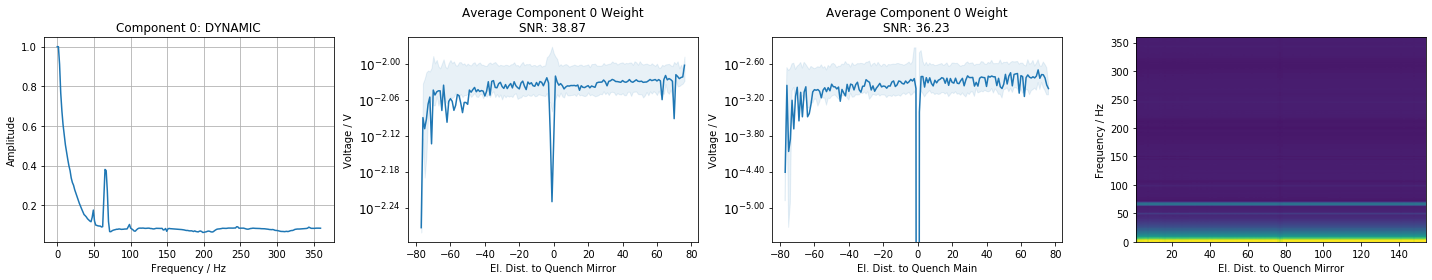

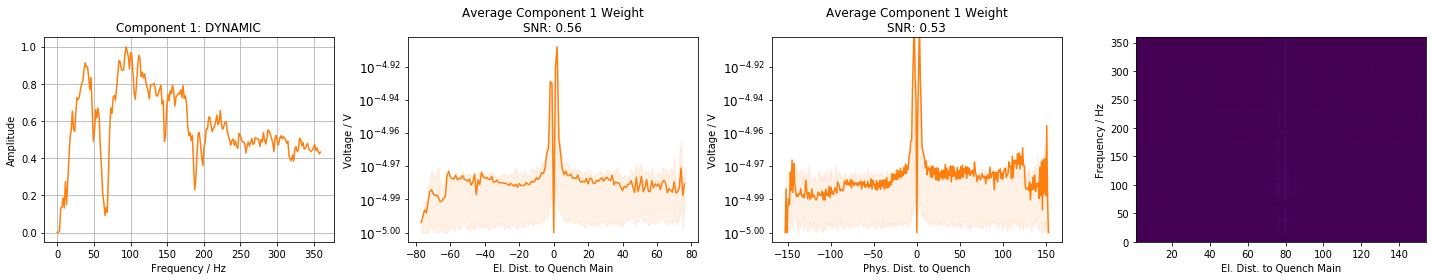

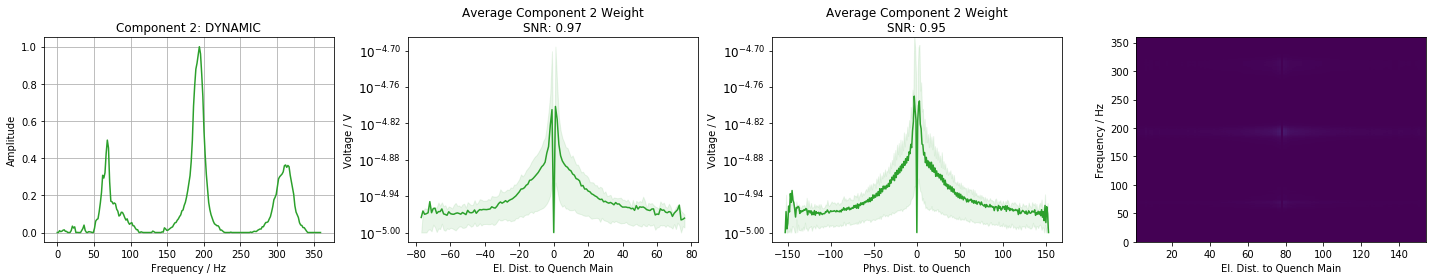

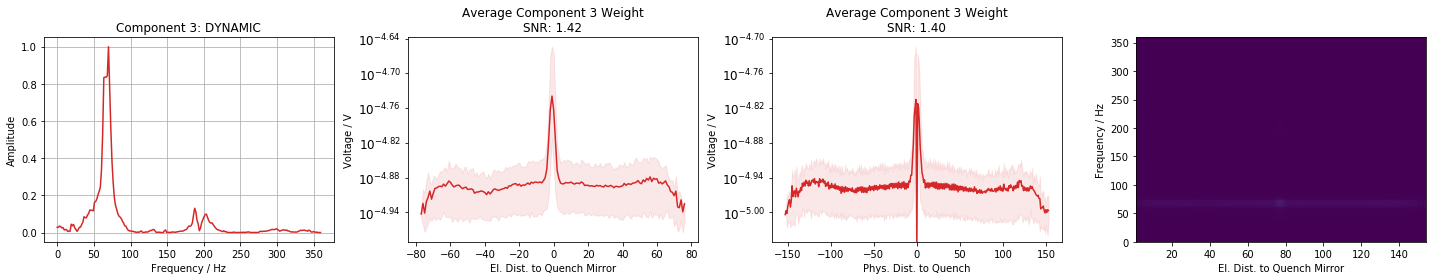

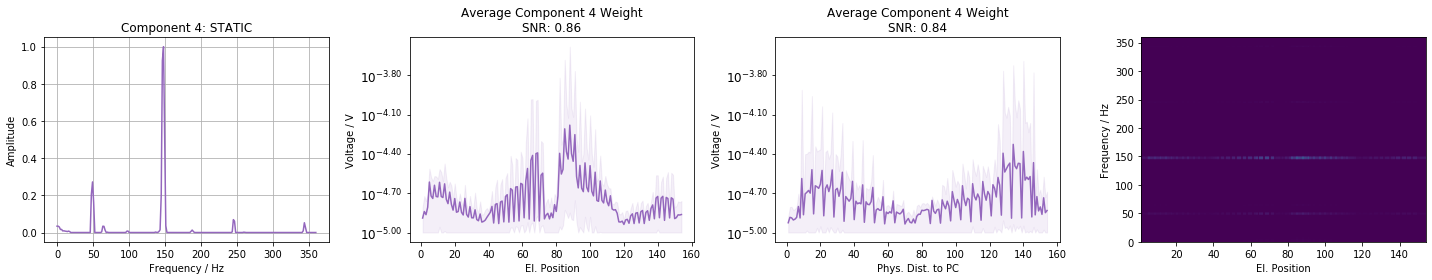

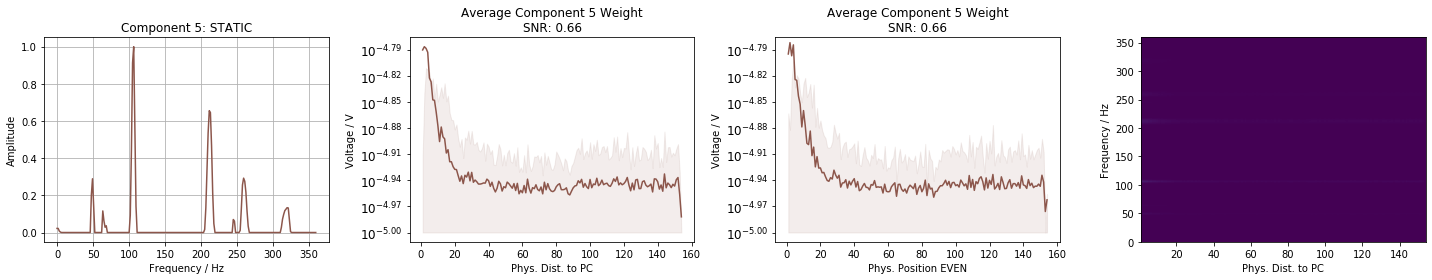

In [33]:
plot_n_highest_snr =  2#len(c_weights_dict_2EE)
n_components = c_weights_dict_2EE["El. Position"]["values"].shape[-1]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2

best_sort_index_2EE = []
for k in range(n_components): 
    
    snr_sorted_index = np.argsort([-c_weights_dict_2EE[sort]["snr"][k] for sort in c_weights_dict_2EE])[:plot_n_highest_snr]
    best_sort_index_2EE.append(snr_sorted_index[0])
    
    fig, ax = plt.subplots(1,plot_n_highest_snr+2, figsize =(5*(plot_n_highest_snr+2),4))
    ax[0].plot(dataset_2EE_fft.frequency, H_2EE_processed[k], c=default_colors[k % n_components])
    ax[0].set_title(f"Component {k}")
    ax[0].set_xlabel("Frequency / Hz")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid()
    
    if "Quench" in list(c_weights_dict_2EE)[snr_sorted_index[0]]:
        ax[0].set_title(f"Component {k}: DYNAMIC")
    else:
        ax[0].set_title(f"Component {k}: STATIC")
    
    for i, sort in enumerate(np.array(list(c_weights_dict_2EE))[snr_sorted_index]):
        plot_avg_component_weight(ax[i+1], c_weights_dict_2EE[sort], component_number=k, xlabel=sort)
        
        yticks = ax[i+1].get_yticks().tolist()
        
        ax[i+1].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
        ax[i+1].set_ylabel("Voltage / V")
        ax[i+1].set_ylim(ax[1].get_ylim())

    
    best_sort = list(c_weights_dict_2EE)[snr_sorted_index[0]]
    V_mean = np.nanmean(c_weights_dict_2EE[best_sort]["values"], axis=0)[:, k:k+1] @  H_2EE_processed[k:k+1]
    plot_position_frequency_map(ax[-1], V_mean, dataset_2EE_fft.frequency, norm=None, vmin=0, vmax=1)
    ax[-1].set_xlabel(best_sort)
    ax[-1].set_ylabel("Frequency / Hz")
    
    plt.tight_layout()

# Simulate FP-map given components for both EE

In [35]:
n_quench_pos = 154
V_mean_2EE = np.zeros((n_quench_pos,) + dataset_2EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index_2EE):
        best_sort = list(c_weights_dict_2EE)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict_2EE[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict_2EE)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict_2EE)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict_2EE)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)
        V_mean_2EE[quench_pos] += V_mean

In [63]:
output_path = Path(f"../output/nmf_decomposition.py/simulation_all")
output_path.mkdir(parents=True, exist_ok=True)

im_paths = []   
circuit = 'RB.A12'
for quench_pos in range(n_quench_pos):
    phys_pos_index = map_position_index(df_pos_map, origin="El. Position", to='Phys. Position', filt={'Circuit': circuit, 'El. Quench Position': quench_pos})
    phys_quench_pos = map_position_index(df_pos_map, old_index=[quench_pos], origin="Phys. Position", to='El. Position', filt={'Circuit': 'RB.A12', 'El. Quench Position': quench_pos})[0]
    
    fig, ax = plt.subplots(2,3, figsize = (15,10), gridspec_kw={ 'width_ratios': [4, 4, 1]})
    
    plot_position_frequency_map(ax[0, 0], V_mean_1EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 0].set_title(f"U_Diode @ 1st EE, El. Quench Position: {quench_pos+1}")
    ax[0, 0].set_ylabel("Frequency / Hz")
    ax[0, 0].set_xlabel("El. Position")
    
    im = plot_position_frequency_map(ax[0, 1], V_mean_1EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[0, 1].set_ylabel("Frequency / Hz")
    ax[0, 1].set_xlabel("Phys. Position")
    
    plot_position_frequency_map(ax[1, 0], V_mean_2EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 0].set_title(f"U_Diode @ 2nd EE, El. Quench Position: {quench_pos}")
    ax[1, 0].set_ylabel("Frequency / Hz")
    ax[1, 0].set_xlabel("El. Position")
    
    plot_position_frequency_map(ax[1, 1], V_mean_2EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[1, 1].set_ylabel("Frequency / Hz")
    ax[1, 1].set_xlabel("Phys. Position")
    
    cbar = fig.colorbar(im, ax=ax[0, 2], fraction=1)
    ax[0, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)
    
    cbar = fig.colorbar(im, ax=ax[1, 2], fraction=1)
    ax[1, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)

    im_path = output_path / f"{quench_pos+1}.png"
    im_paths.append(im_path)
    plt.tight_layout()
    plt.savefig(im_path)
    plt.close(fig)

In [64]:
from PIL import Image
imgs = (Image.open(f) for f in im_paths)
img = next(imgs)  # extract first image from iterator
img.save(fp=output_path / "summary.gif", format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)